## Limpeza/Tratamento da base

In [1]:
!pip install fuzzywuzzy

In [2]:
# importando bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
import fuzzywuzzy
from fuzzywuzzy import process

/home/arthur/anaconda3/lib/python3.9/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [3]:
# lendo os dados e fazendo observações
df = pd.read_csv("base0.csv")
df.head()

,V1,Grupo,Grupos2,@01Idadeanoscompletos,@02Estadocivil,@03EscolaridadeAnosdeestudo,@03.1Escolaridade,@04RendaFamiliaremsaláriosmínimos,@05Ocupação,t1,...,t3@55RoturaPrematuradeMembranas,@71_IG_na_resolução,t4@72Sexo,@73Pesoemgramas,@73.1ClassificaçãoPeso,@74Apgarno1ºminuto,@75Apgarno5ºminuto,@76MétododeaferiçãodeIG,t4@77UsodeOxigênio,Óbito
0,3/26/2018,Caso,1,27,Com companheiro,13,Ensino médio incompleto,,Não trabalha,Parda,...,Sim,29.000000,Masculino,1175,AIG,8,9,US 1º/2º trimestre,Sim,2
1,4/26/2018,Caso,1,25,Com companheiro,0,Analfabeta,,Não trabalha,Parda,...,Sim,23.714286,Masculino,665,AIG,2,4,US 1º/2º trimestre,Sim,1
2,5/31/2018,Caso,3,27,Com companheiro,10,Ensino médio incompleto,,Não trabalha,Parda,...,Não,35.857143,Feminino,1890,PIG,3,6,DUM,Sim,2
3,5/31/2018,Controle Antes,1,24,Sem companheiro,7,Ensino fundamental incompleto,,Não trabalha,Parda,...,Sim,39.428571,Masculino,3280,AIG,8,9,Capurro,Não,2
4,5/31/2018,Controle Depois,1,38,Com companheiro,8,Ensino fundamental,,Não trabalha,Parda,...,Não,37.857143,Masculino,3525,AIG,8,9,US 1º/2º trimestre,Não,2


Um primeiro olhar sobre os dados nos indica os seguintes **problemas**: 

* nomes das colunas difíceis de ler
* coluna de datas fora do padrão brasileiro
* várias colunas do tipo Object mas que deveriam estar como strings/categorical
* colunas como *Escolaridade, Procedência, Renda familiar, Sexo e Ocupação* têm inconsistências
* coluna *Peregrinação* tem apenas um dado
* não há valores *NA ou Null*, porém, há string vazias no dataframe
* a coluna *obito* tem valores 1 e 2 para **não-óbito** e **óbito** respectivamente

In [4]:
# renomeando as colunas e corrigindo alguns campos
# hac = hipertensão arterial crônica
# drc = doença renal crônica
# dr = doenças renais
col_names = ['data', 'grupo1', 'grupo2', 'idade', 'estado_civil', 'anos_de_estudo', 'escolaridade', 'renda_familiar',
            'ocupacao', 'ident_racial', 'procedencia', 'num_gestacoes', 'num_partos', 'num_abortos', 'num_cesarias_previas', 
            'num_filhos_vivos', 'pre_natal', 'mesma_pessoa_pre_natal', 'num_consulta_prenatal', 'igpn', 'altura(cm)', 
            'peso_ini_pre_natal(kg)', 'peso_fim_pre_natal(kg)', 'dificuldade_no_pre_natal', 'peregrinacao', 'hac', 'obesidade', 
            'baixo_peso', 'diabetes_melitus', 'tabagismo', 'doencas_cardiacas', 'drc', 'dr', 'hiv_aids', 'tireoidopatias', 
            'lupus', 'asma', 'sifilis', 'anemia_hemoglobina_10g', 'itu', 'pre_eclampsia', 'eclampsia', 'sindrome_hellp',
            'sepse', 'trabalho_parto_prematuro', 'hemorragia_severa', 'uso_sulfato_magnesio', 'internacao_uti',
            'transfusao_hemovariados', 'rotura_prematura_membranas', 'ig_resolucao', 'sexo', 'peso(g)', 'classificacao_peso',
            'apgar_1minuto', 'apgar_5minuto', 'metodo_afericao_ig', 'oxigenio', 'obito']

df.columns = col_names
df.head()

,data,grupo1,grupo2,idade,estado_civil,anos_de_estudo,escolaridade,renda_familiar,ocupacao,ident_racial,...,rotura_prematura_membranas,ig_resolucao,sexo,peso(g),classificacao_peso,apgar_1minuto,apgar_5minuto,metodo_afericao_ig,oxigenio,obito
0,3/26/2018,Caso,1,27,Com companheiro,13,Ensino médio incompleto,,Não trabalha,Parda,...,Sim,29.000000,Masculino,1175,AIG,8,9,US 1º/2º trimestre,Sim,2
1,4/26/2018,Caso,1,25,Com companheiro,0,Analfabeta,,Não trabalha,Parda,...,Sim,23.714286,Masculino,665,AIG,2,4,US 1º/2º trimestre,Sim,1
2,5/31/2018,Caso,3,27,Com companheiro,10,Ensino médio incompleto,,Não trabalha,Parda,...,Não,35.857143,Feminino,1890,PIG,3,6,DUM,Sim,2
3,5/31/2018,Controle Antes,1,24,Sem companheiro,7,Ensino fundamental incompleto,,Não trabalha,Parda,...,Sim,39.428571,Masculino,3280,AIG,8,9,Capurro,Não,2
4,5/31/2018,Controle Depois,1,38,Com companheiro,8,Ensino fundamental,,Não trabalha,Parda,...,Não,37.857143,Masculino,3525,AIG,8,9,US 1º/2º trimestre,Não,2


In [5]:
# verificando as inconsistências da coluna
esc = df['escolaridade'].unique()
sorted(esc)

[' ',
 'Analfabeta',
 'ENSINO MÉDIO',
 'Ensino  Fundamental',
 'Ensino fundamental',
 'Ensino fundamental incompleto',
 'Ensino medio',
 'Ensino medio incompleto',
 'Ensino medio incopleto',
 'Ensino médio',
 'Ensino médio incompleto',
 'Ensino superior',
 'Ensino superior incompleto',
 'ensino medio',
 'ensino médio',
 'ensino superior']

In [6]:
# usando o pacote fuzzywuzzy para checar e corrigir essas inconsistências
matches = fuzzywuzzy.process.extract('Ensino Médio', esc, limit=16, scorer=fuzzywuzzy.fuzz.token_sort_ratio) 
matches

[('Ensino médio', 100),
 ('ensino médio', 100),
 ('ENSINO MÉDIO', 100),
 ('ensino medio', 96),
 ('Ensino medio', 96),
 ('Ensino superior', 69),
 ('ensino superior', 69),
 ('Ensino médio incompleto', 67),
 ('Ensino medio incopleto', 67),
 ('Ensino medio incompleto', 65),
 ('Ensino fundamental', 55),
 ('Ensino  Fundamental', 55),
 ('Ensino superior incompleto', 54),
 ('Ensino fundamental incompleto', 50),
 ('Analfabeta', 10),
 (' ', 0)]

In [7]:
# função para consertar inconsistências nas strings
def replace_matches_in_column(df, column, string_to_match, min_ratio = 90):
    # pega os valores da coluna do dataframe
    strings = df[column].unique()
    
    # encontra os matches
    matches = fuzzywuzzy.process.extract(string_to_match, strings, limit=150, 
                                                   scorer=fuzzywuzzy.fuzz.token_sort_ratio)
    
    # pega matches a partir de 90 pontos
    close_matches = [matches[0] for matches in matches if matches[1] >= min_ratio]
    
    # compara as strings do dataframe com os close_matches
    rows_with_matches = df[column].isin(close_matches)
    
    # faz a reposição do valor encontrado
    df.loc[rows_with_matches, column] = string_to_match

In [8]:
# corrigindo algumas inconsistências de strings
df['ocupacao'] = df['ocupacao'].str.lower() # pondo todos os dados da coluna como lower case
df.drop(columns=['peregrinacao'], inplace=True) # deletando a coluna por ter um dado somente
df['sexo'] = df['sexo'].str.lower() # pondo todos os dados da coluna como lower case
df['sexo'].replace({'masculino': 'M', 'feminino': 'F', 'indeterminado': 'IND'}, inplace=True) # alterando valores para melhorar leitura
df['mesma_pessoa_pre_natal'].replace({'nao': 'Não'}, inplace=True) # inconsistência em um único valor

replace_matches_in_column(df, 'escolaridade', 'Ensino fundamental')
replace_matches_in_column(df, 'escolaridade', 'Ensino médio')
replace_matches_in_column(df, 'escolaridade', 'Ensino superior')
replace_matches_in_column(df, 'escolaridade', 'Ensino médio incompleto')
replace_matches_in_column(df, 'renda_familiar', 'Um salário mínimo')
replace_matches_in_column(df, 'procedencia', 'Capital e RM')
replace_matches_in_column(df, 'procedencia', 'Interior')

In [9]:
# substituir valores de string vazias por NaN values
# calcular porcentagem de dados faltantes
df.replace(r'^\s*$', np.nan, regex=True, inplace=True)

total = np.product(df.shape)
missing = df.isna().sum().sum()
perc_missing = missing/total*100
print('Aproximadamente {} dos dados estão vazios.'.format(str(round(perc_missing, 4)) + '%'))

Aproximadamente 3.0536% dos dados estão vazios.


Como há uma quantidade significativa de dados faltantes no dataset, é aconselhável a **não exclusão** desses valores.  

Iremos então, completar esses campos usando alguns métodos que nos permitirão fazer análises sem comprometer os resultados finais. 

In [10]:
# substituindo valores NaN de algumas colunas
df[['renda_familiar', 'procedencia', 'ocupacao', 'escolaridade', 'dificuldade_no_pre_natal']] = df[['renda_familiar', 'procedencia', 'ocupacao', 'escolaridade', 'dificuldade_no_pre_natal']].fillna('Não respondeu') 
df['renda_familiar'].unique()

array(['Não respondeu', 'Um salário mínimo',
       'Maior que um salário mínimo', 'Menor que um salário mínimo'],
      dtype=object)

In [11]:
# padronizando as datas para o formato dd/mm/aa
df['data'] = df['data'].fillna(method='ffill')
df['data'] = pd.to_datetime(df['data'], infer_datetime_format=True).dt.strftime('%d/%m/%Y')
df['data'].head()

0    26/03/2018
1    26/04/2018
2    31/05/2018
3    31/05/2018
4    31/05/2018
Name: data, dtype: object

Vamos completar os dados faltantes através do atributo *ffill*, do método *fillna* do pandas.  
Esse método coleta a última observação válida de uma 'célula' e a repassa à frente, para uma 'célula' de valor *na* ou *null*.  
Confira a documentação [aqui](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.fillna.html) para saber mais sobre o método *fillna* e seus atributos. 

In [12]:
# completando dados faltantes
df.fillna(method='ffill', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1092 entries, 0 to 1091
Data columns (total 58 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   data                        1092 non-null   object 
 1   grupo1                      1092 non-null   object 
 2   grupo2                      1092 non-null   int64  
 3   idade                       1092 non-null   int64  
 4   estado_civil                1092 non-null   object 
 5   anos_de_estudo              1092 non-null   object 
 6   escolaridade                1092 non-null   object 
 7   renda_familiar              1092 non-null   object 
 8   ocupacao                    1092 non-null   object 
 9   ident_racial                1092 non-null   object 
 10  procedencia                 1092 non-null   object 
 11  num_gestacoes               1092 non-null   int64  
 12  num_partos                  1092 non-null   int64  
 13  num_abortos                 1092 

In [13]:
# observando strings inconsistentes na coluna 'ocupacao'
sorted(df['ocupacao'].unique())

[' tecnica de saúde bucal',
 'Não respondeu',
 'a',
 'administradora',
 'agente administrativa',
 'agente comunitária de saúde',
 'agente comunitário de saúde',
 'agricultora',
 'agricultura',
 'assistente administrativa',
 'assistente odontológica',
 'assistência recursos humanos',
 'assitente de rh',
 'atendente',
 'atendente administrativo',
 'atendente de farmácia',
 'atendente de lanchonete',
 'atendente de loja',
 'atendente na fabrica de calçados',
 'autonoma',
 'autonôma',
 'autônoma',
 'auxiliar administrativa',
 'auxiliar administrativo',
 'auxiliar de atendente',
 'auxiliar de conzinha',
 'auxiliar de costureira',
 'auxiliar de cozinha',
 'auxiliar de escritorio',
 'auxiliar de escritório',
 'auxiliar de laboratorio',
 'auxiliar de loja',
 'auxiliar de produção',
 'auxiliar de professora',
 'auxiliar de serviços gerais',
 'babá',
 'balconista',
 'bordadeira',
 'cabeleleira',
 'cabelereira',
 'caixa',
 'caixa de supermercado',
 'camareira',
 'cambista',
 'chefe de cozinha',
 

É possível ver que a coluna acima é muito volumosa, contendo várias strings mal formatadas que podem indicar a mesma profissão.  
Diante disso, vamos criar uma função capaz de consertar essas inconsistências, de modo que também diminua o espaço de memória utilizado pela coluna de ocupação. 

In [14]:
# função para fazer limpeza dos nomes dos cargos
def cleaning_the_names(job):
    if job.__contains__('bucal'):
        return 'técnica de sáude bucal'
    elif job.__contains__('assistência recursos humanos')|job.__contains__('assitente de rh'):
        return 'assistente de rh'
    elif job.__contains__('atendente'):
        return 'atendente'
    elif job.__contains__('aut'):
        return 'autônoma'
    elif job.__contains__('auxiliar de conzinha'):
        return 'auxiliar de cozinha'
    elif job.__contains__('auxiliar de escritorio'):
        return 'auxiliar de escritório'
    elif job.__contains__('cabele'):
        return 'cabeleireira'
    elif job.__contains__('caixa'):
        return 'caixa'
    elif job.__contains__('confec'):
        return 'confeccionista'
    elif job.__contains__('conzinheira'):
        return 'cozinheira'
    elif job.__contains__('costu'):
        return 'costureira'
    elif job.__contains__('cuidadora'):
        return 'cuidadora'
    elif job.__contains__('domestica'):
        return 'doméstica'
    elif job.__contains__('educa'):
        return 'educadora de trânsito'
    elif job.__contains__('empresaria')|job.__contains__('empresária'):
        return 'empresária'
    elif job.__contains__('micro'):
        return 'microempresária'
    elif job.__contains__('tecnica de enfermagem')|job.__contains__('técnica de emfermagem'):
        return 'técnica de enfermagem'
    elif job.__contains__('vendedo')|job.__contains__('vende')|job.__contains__('vendas'):
        return 'vendedora'
    elif job.__contains__('sim'):
        return 'Não respondeu'
    elif job == 'a':
        return 'Não respondeu'
    else:
        return job

In [15]:
# aplicando a função no dataframe e verificando em seguida
df['ocupacao'] = df['ocupacao'].map(cleaning_the_names)
sorted(df['ocupacao'].unique())

['Não respondeu',
 'administradora',
 'agente administrativa',
 'agente comunitária de saúde',
 'agente comunitário de saúde',
 'agricultora',
 'agricultura',
 'assistente administrativa',
 'assistente de rh',
 'assistente odontológica',
 'atendente',
 'autônoma',
 'auxiliar administrativa',
 'auxiliar administrativo',
 'auxiliar de cozinha',
 'auxiliar de escritório',
 'auxiliar de laboratorio',
 'auxiliar de loja',
 'auxiliar de produção',
 'auxiliar de professora',
 'auxiliar de serviços gerais',
 'babá',
 'balconista',
 'bordadeira',
 'cabeleireira',
 'caixa',
 'camareira',
 'cambista',
 'chefe de cozinha',
 'colégio farias brito',
 'comerciante',
 'como embaladora',
 'confeccionista',
 'consultora',
 'cortadeira',
 'costureira',
 'cozinheira',
 'cuidadora',
 'decoradora',
 'depiladora',
 'diarista',
 'doméstica',
 'educadora de trânsito',
 'empresária',
 'enfermeira',
 'estagiária dos recursos humanos',
 'faxineira',
 'feirante',
 'fiscal de loja',
 'fisioterapeuta',
 'garçonete',

Após concluída a limpeza, devemos transformar os dtypes das colunas para seus valores corretos, como passar:

* *object* $\rightarrow$ *string*
* *string* $\rightarrow$ *float*
* *string* $\rightarrow$ *int*

Caso a base possua uma quantidade muito maior de registros, a fim de reduzir a quantidade de memória em uso, bem como obter mais performance nas ações tomadas, poderíamos transformar as colunas de *string* para o dtype *categorical*.

In [16]:
# parsing das colunas
df['grupo1'] = df['grupo1'].astype('string')
df['grupo2'] = df['grupo2'].astype(int)
df['estado_civil'] = df['estado_civil'].astype('string')
df['anos_de_estudo'] = df['anos_de_estudo'].astype(int)
df['escolaridade'] = df['escolaridade'].astype('string')
df['renda_familiar'] = df['renda_familiar'].astype('string')
df['ocupacao'] = df['ocupacao'].astype('string')
df['ident_racial'] = df['ident_racial'].astype('string')
df['procedencia'] = df['procedencia'].astype('string')
df['pre_natal'] = df['pre_natal'].astype('string')
df['mesma_pessoa_pre_natal'] = df['mesma_pessoa_pre_natal'].astype('string')
df['num_consulta_prenatal'] = df['num_consulta_prenatal'].astype(int)
df['altura(cm)'] = df['altura(cm)'].astype(int)
df['peso_ini_pre_natal(kg)'] = df['peso_ini_pre_natal(kg)'].astype(float)
df['peso_fim_pre_natal(kg)'] = df['peso_fim_pre_natal(kg)'].astype(float)
df['dificuldade_no_pre_natal'] = df['dificuldade_no_pre_natal'].astype('string')
df['hac'] = df['hac'].astype('string')
df['obesidade'] = df['obesidade'].astype('string')
df['baixo_peso'] = df['baixo_peso'].astype('string')
df['diabetes_melitus'] = df['diabetes_melitus'].astype('string')
df['tabagismo'] = df['tabagismo'].astype('string')
df['doencas_cardiacas'] = df['doencas_cardiacas'].astype('string')
df['drc'] = df['drc'].astype('string')
df['dr'] = df['dr'].astype('string')
df['hiv_aids'] = df['hiv_aids'].astype('string')
df['tireoidopatias'] = df['tireoidopatias'].astype('string')
df['lupus'] = df['lupus'].astype('string')
df['asma'] = df['asma'].astype('string')
df['sifilis'] = df['sifilis'].astype('string')
df['anemia_hemoglobina_10g'] = df['anemia_hemoglobina_10g'].astype('string')
df['itu'] = df['itu'].astype('string')
df['pre_eclampsia'] = df['pre_eclampsia'].astype('string')
df['eclampsia'] = df['eclampsia'].astype('string')
df['sindrome_hellp'] = df['sindrome_hellp'].astype('string')
df['sepse'] = df['sepse'].astype('string')
df['trabalho_parto_prematuro'] = df['trabalho_parto_prematuro'].astype('string')
df['hemorragia_severa'] = df['hemorragia_severa'].astype('string')
df['uso_sulfato_magnesio'] = df['uso_sulfato_magnesio'].astype('string')
df['internacao_uti'] = df['internacao_uti'].astype('string')
df['transfusao_hemovariados'] = df['transfusao_hemovariados'].astype('string')
df['rotura_prematura_membranas'] = df['rotura_prematura_membranas'].astype('string')
df['sexo'] = df['sexo'].astype('string')
df['classificacao_peso'] = df['classificacao_peso'].astype('string')
df['metodo_afericao_ig'] = df['metodo_afericao_ig'].astype('string')
df['oxigenio'] = df['oxigenio'].astype('string')

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1092 entries, 0 to 1091
Data columns (total 58 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   data                        1092 non-null   object 
 1   grupo1                      1092 non-null   string 
 2   grupo2                      1092 non-null   int64  
 3   idade                       1092 non-null   int64  
 4   estado_civil                1092 non-null   string 
 5   anos_de_estudo              1092 non-null   int64  
 6   escolaridade                1092 non-null   string 
 7   renda_familiar              1092 non-null   string 
 8   ocupacao                    1092 non-null   string 
 9   ident_racial                1092 non-null   string 
 10  procedencia                 1092 non-null   string 
 11  num_gestacoes               1092 non-null   int64  
 12  num_partos                  1092 non-null   int64  
 13  num_abortos                 1092 

A seguir, vamos deletar alguns registros da base, pois tais não entram adequadamente nas nossas análises futuras. 

In [18]:
df = df[df['procedencia'] != 'Não respondeu']
df = df[df['hac'] != 'Ignorado']
df = df[df['diabetes_melitus'] != 'Ignorado']
df = df[df['tabagismo'] != 'Ignorado']
df = df[df['sexo'] != 'IND']

Por último, devemos transformar as informações da coluna *obito* para algo que possa ser melhor entendido, já que os dados dessa coluna (1 e 2) representam ocorrência ou não de óbitos.  

Assim, podemos substituir 1 e 2 por 0 e 1, relacionando a **não-óbito** e a **óbito** respectivamente. 

Também é possível substituir 2 e 1 por **Sim** e **Não**.

In [19]:
# transformando os dados da coluna 'obito'
df['obito'] = df['obito'].apply(lambda x: 0 if x==1 else 1)
df['obito'].value_counts()

1    989
0     93
Name: obito, dtype: int64

In [20]:
df.to_csv(path_or_buf='/home/arthur/Documentos/PET/PET - Pesquisa/base1(clean).csv', index=False)

## Análise Exploratória de Dados

### Tipos de variáveis

* **Qualitativas**

    * *Nominais* (34)
        * estado_civil
        * ocupacao
        * ident_racial
        * procedencia
        * **pre_natal**
        * mesma_pessoa_pre_natal
        * **dificuldade_pre_natal**
        * **hac**
        * **obesidade**
        * baixo_peso
        * **diabetes_melitus**
        * **tabagismo**
        * **doencas_cardiacas**
        * drc
        * dr
        * hiv_aids
        * tireoidopatias
        * lupus
        * asma
        * sifilis
        * anemia_hemoglobina
        * itu
        * pre_eclampsia
        * eclampsia
        * sindrome_hellp
        * sepse
        * **trabalho_parto_prematuro**
        * **hemorragia_severa**
        * uso_sulfato_magnesio
        * **internacao_uti**
        * transfusao_hemovariados
        * rotura_prematura_membranas
        * **sexo**
        * **oxigenio**  
        
    * *Ordinais* (5)
        * grupo1
        * escolaridade
        * renda_familiar
        * classificacao_peso
        * metodo_afericao_ig
        
* **Quantitativas**

    * *Discretas* (13)
        * data
        * grupo2
        * idade
        * anos_de_estudo
        * num_gestacoes
        * num_partos
        * num_abortos
        * num_cesarias_previas
        * num_filhos_vivos
        * num_consulta_prenatal
        * **apgar_1minuto**
        * **apgar_5minuto**
        * obito
        
    * *Contínuas* (6)
        * igpn
        * altura(cm)
        * peso_ini_pre_natal(kg)
        * peso_fim_pre_natal(kg)
        * ig_resolucao
        * peso(g)

Qual a média, mediana, variância e desvio-padrão da variável *idade*?

In [21]:
print(df['idade'].describe().round(3))

count    1082.000
mean       26.387
std         7.236
min        12.000
25%        20.000
50%        26.000
75%        32.000
max        48.000
Name: idade, dtype: float64


Qual a frequência do *nº de óbitos* em relação à se enfrentou ou não *dificuldade no pré-natal*?

In [22]:
pd.crosstab(df['dificuldade_no_pre_natal'], df['obito'], margins=True, margins_name="Total")

obito,0,1,Total
dificuldade_no_pre_natal,,,
Não,21,294,315
Não respondeu,63,605,668
Sim,9,90,99
Total,93,989,1082


Curiosamente, o número de óbitos foi maior dentre aqueles que **não** tiveram nenhuma dificuldade na realização do pré-natal, porém, é importante levar em consideração que muitas pessoas não responderam. 

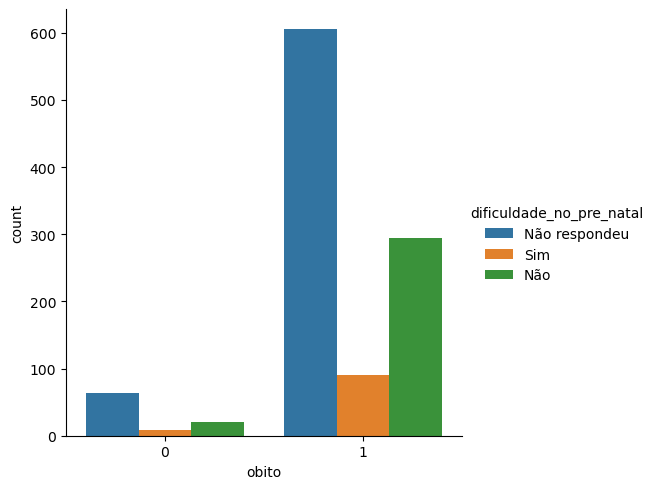

In [23]:
sns.catplot(data=df, x='obito', hue='dificuldade_no_pre_natal', kind='count')

Qual a frequência das variáveis *escolaridade* e *renda_familiar*?

In [24]:
print('Frequência de \'escolaridade\': \n')
print(df['escolaridade'].value_counts())

print('\nFrequência de \'renda_familiar\': \n')
print(df['renda_familiar'].value_counts())

Frequência de 'escolaridade': 

Ensino médio                     324
Ensino fundamental incompleto    312
Ensino médio incompleto          212
Ensino fundamental               115
Ensino superior                   65
Ensino superior incompleto        38
Analfabeta                        15
Não respondeu                      1
Name: escolaridade, dtype: Int64

Frequência de 'renda_familiar': 

Não respondeu                  656
Um salário mínimo              199
Maior que um salário mínimo    131
Menor que um salário mínimo     96
Name: renda_familiar, dtype: Int64


Agora, vamos fazer um **agrupamento por _ocupacao_** e em seguida somar a quantidade de óbitos para cada ocupação.  
Iremos ainda, ordenar o dataframe por **ordem decrescente** do nº de óbitos.

In [25]:
df.groupby('ocupacao', as_index=False)['obito'].sum().sort_values(by='obito', ascending=False).head(10)

,ocupacao,obito
58,não trabalha,600
34,costureira,63
5,agricultora,36
77,vendedora,27
63,professora,23
10,autônoma,19
24,caixa,16
9,atendente,15
40,doméstica,14
23,cabeleireira,12


Logo, é possível ver que o número de perdas de bebês é quase 10x maior entre desempregados, em comparação com as outras 82 profissões registradas na base. 

Criaremos um dataframe contendo algumas varíaveis para em seguida encontrar suas **medidas descritivas**.  

In [26]:
df2 = df[['num_gestacoes', 'num_partos', 'num_abortos', 'num_cesarias_previas', 'num_filhos_vivos']]
df2.describe(include='all').round(3)

,num_gestacoes,num_partos,num_abortos,num_cesarias_previas,num_filhos_vivos
count,1082.000,1082.000,1082.000,1082.000,1082.000
mean,2.323,1.005,0.322,0.307,0.990
std,1.609,1.303,0.741,0.652,1.293
min,1.000,0.000,0.000,0.000,0.000
25%,1.000,0.000,0.000,0.000,0.000
50%,2.000,1.000,0.000,0.000,1.000
75%,3.000,2.000,0.000,0.000,2.000
max,17.000,12.000,10.000,4.000,12.000


A seguir, construímos tabelas de dupla entrada entre possíveis variáveis relacionadas a *obito*:

In [27]:
pd.crosstab(df.oxigenio, df.obito)

obito,0,1
oxigenio,,
Não,0,592
Sim,93,397


In [28]:
pd.crosstab(df.obito, [df.classificacao_peso, df.internacao_uti], margins_name="Total", margins=True)

classificacao_peso AIG       GIG       PIG       Total
internacao_uti       Não Sim   Não Sim   Não Sim      
obito                                                 
0                     65   4     1   0    23   0    93
1                    763  23    91   1    98  13   989
Total                828  27    92   1   121  13  1082

In [29]:
pd.crosstab(df['sepse'], df['obito'])

obito,0,1
sepse,,
Não,92,988
Sim,1,1


In [30]:
pd.crosstab(df['obesidade'], df['obito'])

obito,0,1
obesidade,,
Ignorado,6,63
Não,72,772
Sim,15,154


In [31]:
pd.crosstab(df['sexo'], df['obito'])

obito,0,1
sexo,,
F,40,496
M,53,493


In [32]:
pd.crosstab(df['apgar_5minuto'], df['obito'])

obito,0,1
apgar_5minuto,,
1,4,0
2,2,1
3,4,3
4,7,10
5,12,11
6,18,28
7,16,45
8,18,161
9,12,685


### Testes Chi-quadrado e Exato de Fisher

Dado o cenário geral e os tipos de variáveis que temos em mãos, torna-se necessário fazer a aplicação dos testes estatísticos *Qui-quadrado* ou *exato de Fisher*. A seguir, mostramos a fórmula matemática para essas duas medidas, bem como o significado de cada uma delas:

1. *Qui-quadrado*: 

  1. $ χ^2 = \sum_{i=1}^{r}\sum_{j=1}^{s}{\frac{(n_{ij}-e_{ij})^2}{e_{ij}}}$, onde $e_{ij}$ é a frequência esperada da categoria *i* da variável X e da categoria *j* da variável Y; 

  2. Para uma maior precisão da $χ^2$, utiliza-se o *coeficiente de contingência de Pearson*, de seguinte expressão: $C = \sqrt{\frac{χ^2}{χ^{2}+n}} $, sendo $n$ o número total de observações;

  3. Essas estatísticas nos permitem identifcar o grau de **associação** entre duas variáveis **qualitativas**, ou seja, indica o grau de comportamento conjunto de duas varíaveis.


2. *Teste exato de Fisher*:

  1. De maneira similar ao teste *qui-quadrado*, o teste exato de Fisher nos permite testar se exite ou não independência entre duas variáveis nominais em uma tabela de contingência 2x2, sendo $H_{0}$ = as variáveis são independentes, e $H_{1}$ = as variáveis **não** são independentes;

  2. O teste leva a uma **distribuição hipergeométrica** dos números, generalizada por: $ p_{k} = \frac{\binom{r}{k}\binom{N - r}{n - k}}{\binom{N}{n}}$.


Iremos implementar essas estatísticas entre algumas variáveis e a variável *Óbito* através da biblioteca **scipy.stats**.

Confira a documentação:

* [Chi-quadrado](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi2_contingency.html)
* [Teste exato de Fisher](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.fisher_exact.html)

In [33]:
from scipy import stats

In [34]:
# escolhendo algumas colunas e em seguida
# usando list comprehension para agrupar os resultados

variables = list(['procedencia', 'pre_natal', 'hac', 'diabetes_melitus', 'tabagismo', 'eclampsia', 'sindrome_hellp', 'trabalho_parto_prematuro', 'internacao_uti', 'sexo', 'oxigenio'])
chi_tests = [stats.chi2_contingency(observed=pd.crosstab(df[x], df['obito'])) for x in variables]
# chi_tests

In [35]:
# repetiremos o código acima para o teste exato de Fisher
# lembrando que a tabela deve ser 2x2

# variables2 = list(['oxigenio', 'sepse', 'internacao_uti'])
fisher_exact_tests = [stats.fisher_exact(pd.crosstab(df[x], df['obito'])) for x in variables]
# fisher_exact_tests

In [36]:
stats.chi2_contingency(observed=pd.crosstab(df['eclampsia'], df['obito']))

(0.14508671422011077,
 0.7032755976326588,
 1,
 array([[ 91.88262477, 977.11737523],
        [  1.11737523,  11.88262477]]))

In [37]:
stats.fisher_exact(pd.crosstab(df['internacao_uti'], df['obito']))

(0.8647584033613446, 0.774136348853917)

In [38]:
vars = ['procedencia', 'pre_natal', 'hac', 'diabetes_melitus', 'tabagismo', 'eclampsia', 'sindrome_hellp', 'trabalho_parto_prematuro', 'internacao_uti', 'sexo', 'oxigenio']

for i in variables:
  print(pd.crosstab(df[i], df['obito']).to_markdown())
  print("\n---\n")

| procedencia   |   0 |   1 |
|:--------------|----:|----:|
| Capital e RM  |  72 | 835 |
| Interior      |  21 | 154 |

---

| pre_natal   |   0 |   1 |
|:------------|----:|----:|
| Não         |   7 |  41 |
| Sim         |  86 | 948 |

---

| hac   |   0 |   1 |
|:------|----:|----:|
| Não   |  82 | 899 |
| Sim   |  11 |  90 |

---

| diabetes_melitus   |   0 |   1 |
|:-------------------|----:|----:|
| Não                |  92 | 950 |
| Sim                |   1 |  39 |

---

| tabagismo   |   0 |   1 |
|:------------|----:|----:|
| Não         |  83 | 934 |
| Sim         |  10 |  55 |

---

| eclampsia   |   0 |   1 |
|:------------|----:|----:|
| Não         |  91 | 978 |
| Sim         |   2 |  11 |

---

| sindrome_hellp   |   0 |   1 |
|:-----------------|----:|----:|
| Não              |  89 | 962 |
| Sim              |   4 |  27 |

---

| trabalho_parto_prematuro   |   0 |   1 |
|:---------------------------|----:|----:|
| Não                        |  13 | 631 |
| Sim        

In [39]:
print("Resultados do teste Chi-Quadrado\n\n")

print("Procedência x Óbito: \n")
print("Chi-Quadrado = {}, p-valor = {}, graus de liberdade = {}".format(chi_tests[0][0].round(5), chi_tests[0][1].round(5), chi_tests[0][2]))

print("\n")

print("Pré-natal x Óbito: \n")
print("Chi-Quadrado = {}, p-valor = {}, graus de liberdade = {}".format(chi_tests[1][0].round(5), chi_tests[1][1].round(5), chi_tests[1][2]))

print("\n")

print("Hipertenção arterial crônica x Óbito: \n")
print("Chi-Quadrado = {}, p-valor = {}, graus de liberdade = {}".format(chi_tests[2][0].round(5), chi_tests[2][1].round(5), chi_tests[2][2]))

print("\n")

print("Diabetes melitus x Óbito: \n")
print("Chi-Quadrado = {}, p-valor = {}, graus de liberdade = {}".format(chi_tests[3][0].round(5), chi_tests[3][1].round(5), chi_tests[3][2]))

print("\n")

print("Tabagismo x Óbito: \n")
print("Chi-Quadrado = {}, p-valor = {}, graus de liberdade = {}".format(chi_tests[4][0].round(5), chi_tests[4][1].round(5), chi_tests[4][2]))

print("\n")

print("Eclâmpsia x Óbito: \n")
print("Chi-Quadrado = {}, p-valor = {}, graus de liberdade = {}".format(chi_tests[5][0].round(5), chi_tests[5][1].round(5), chi_tests[5][2]))

print("\n")

print("Síndrome de Hellp x Óbito: \n")
print("Chi-Quadrado = {}, p-valor = {}, graus de liberdade = {}".format(chi_tests[6][0].round(5), chi_tests[6][1].round(5), chi_tests[6][2]))

print("\n")

print("Trabalho de parto prematuro x Óbito: \n")
print("Chi-Quadrado = {}, p-valor = {}, graus de liberdade = {}".format(chi_tests[7][0].round(5), chi_tests[7][1].round(5), chi_tests[7][2]))

print("\n")

print("Internação na UTI x Óbito: \n")
print("Chi-Quadrado = {}, p-valor = {}, graus de liberdade = {}".format(chi_tests[8][0].round(5), chi_tests[8][1].round(5), chi_tests[8][2]))

print("\n")

print("Sexo x Óbito: \n")
print("Chi-Quadrado = {}, p-valor = {}, graus de liberdade = {}".format(chi_tests[9][0].round(5), chi_tests[9][1].round(5), chi_tests[9][2]))

print("\n")

print("Oxigênio x Óbito: \n")
print("Chi-Quadrado = {}, p-valor = {}, graus de liberdade = {}".format(chi_tests[10][0].round(5), chi_tests[10][1].round(5), chi_tests[10][2]))

Resultados do teste Chi-Quadrado


Procedência x Óbito: 

Chi-Quadrado = 2.58517, p-valor = 0.10787, graus de liberdade = 1


Pré-natal x Óbito: 

Chi-Quadrado = 1.56428, p-valor = 0.21104, graus de liberdade = 1


Hipertenção arterial crônica x Óbito: 

Chi-Quadrado = 0.45984, p-valor = 0.4977, graus de liberdade = 1


Diabetes melitus x Óbito: 

Chi-Quadrado = 1.24113, p-valor = 0.26525, graus de liberdade = 1


Tabagismo x Óbito: 

Chi-Quadrado = 3.19018, p-valor = 0.07408, graus de liberdade = 1


Eclâmpsia x Óbito: 

Chi-Quadrado = 0.14509, p-valor = 0.70328, graus de liberdade = 1


Síndrome de Hellp x Óbito: 

Chi-Quadrado = 0.29507, p-valor = 0.58699, graus de liberdade = 1


Trabalho de parto prematuro x Óbito: 

Chi-Quadrado = 85.52573, p-valor = 0.0, graus de liberdade = 1


Internação na UTI x Óbito: 

Chi-Quadrado = 0.0, p-valor = 1.0, graus de liberdade = 1


Sexo x Óbito: 

Chi-Quadrado = 1.46013, p-valor = 0.22691, graus de liberdade = 1


Oxigênio x Óbito: 

Chi-Quadra

In [40]:
print("Resultados do Teste exato de Fisher\n\n")

print("Procedência x Óbito: \n")
print("OR = {}, p-valor = {}".format(fisher_exact_tests[0][0].round(5), fisher_exact_tests[0][1].round(5)))

print("\n")

print("Pré-natal x Óbito: \n")
print("OR = {}, p-valor = {}".format(fisher_exact_tests[1][0].round(5), fisher_exact_tests[1][1].round(5)))

print("\n")

print("Hipertenção arterial crônica x Óbito: \n")
print("OR = {}, p-valor = {}".format(fisher_exact_tests[2][0].round(5), fisher_exact_tests[2][1].round(5)))

print("\n")

print("Diabetes melitus x Óbito: \n")
print("OR = {}, p-valor = {}".format(fisher_exact_tests[3][0].round(5), fisher_exact_tests[3][1].round(5)))

print("\n")

print("Tabagismo x Óbito: \n")
print("OR = {}, p-valor = {}".format(fisher_exact_tests[4][0].round(5), fisher_exact_tests[4][1].round(5)))

print("\n")

print("Eclâmpsia x Óbito: \n")
print("OR = {}, p-valor = {}".format(fisher_exact_tests[5][0].round(5), fisher_exact_tests[5][1].round(5)))

print("\n")

print("Síndrome de Hellp x Óbito: \n")
print("OR = {}, p-valor = {}".format(fisher_exact_tests[6][0].round(5), fisher_exact_tests[6][1].round(5)))

print("\n")

print("Trabalho de parto prematuro x Óbito: \n")
print("OR = {}, p-valor = {}".format(fisher_exact_tests[7][0].round(5), fisher_exact_tests[7][1].round(5)))

print("\n")

print("Internação na UTI x Óbito: \n")
print("OR = {}, p-valor = {}".format(fisher_exact_tests[8][0].round(5), fisher_exact_tests[8][1].round(5)))

print("\n")

print("Sexo x Óbito: \n")
print("OR = {}, p-valor = {}".format(fisher_exact_tests[9][0].round(5), fisher_exact_tests[9][1].round(5)))

print("\n")

print("Oxigênio x Óbito: \n")
print("OR = {}, p-valor = {}".format(fisher_exact_tests[10][0].round(5), fisher_exact_tests[10][1].round(5)))

Resultados do Teste exato de Fisher


Procedência x Óbito: 

OR = 0.63234, p-valor = 0.10347


Pré-natal x Óbito: 

OR = 1.88202, p-valor = 0.17924


Hipertenção arterial crônica x Óbito: 

OR = 0.74628, p-valor = 0.35491


Diabetes melitus x Óbito: 

OR = 3.77684, p-valor = 0.24703


Tabagismo x Óbito: 

OR = 0.48876, p-valor = 0.06289


Eclâmpsia x Óbito: 

OR = 0.51176, p-valor = 0.30915


Síndrome de Hellp x Óbito: 

OR = 0.62448, p-valor = 0.3323


Trabalho de parto prematuro x Óbito: 

OR = 0.09219, p-valor = 0.0


Internação na UTI x Óbito: 

OR = 0.86476, p-valor = 0.77414


Sexo x Óbito: 

OR = 0.75015, p-valor = 0.19478


Oxigênio x Óbito: 

OR = 0.0, p-valor = 0.0
